In [171]:
import pandas as pd
import numpy as np

In [172]:
df = pd.read_csv('dataset/train.csv')

In [173]:
df.shape

(36992, 25)

In [174]:
df.columns

Index(['customer_id', 'Name', 'age', 'gender', 'security_no',
       'region_category', 'membership_category', 'joining_date',
       'joined_through_referral', 'referral_id', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_time',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score'],
      dtype='object')

In [175]:
def _joined_through_ref_cleaner(row):
    yesOrNo = 'Yes' if row["referral_id"] != 'xxxxxxxx' else 'No'
    row['joined_through_referral'] = yesOrNo if (row['joined_through_referral'] == '?') else row['joined_through_referral']
    return row

def joined_through_ref_cleaner(df):
    df2 = df.apply(lambda row:_joined_through_ref_cleaner(row),axis=1)
    return df2

In [176]:
def dropAllNA(df):
    df["gender"] = df["gender"].replace("Unknown",np.NaN)
    df["avg_frequency_login_days"] = df["avg_frequency_login_days"].replace("Error",np.NaN)
    df["avg_frequency_login_days"] = df["avg_frequency_login_days"].replace(-999,0.0)
    df["days_since_last_login"] = df["days_since_last_login"].replace(-999,30)
#     df["medium_of_operation"] = df["medium_of_operation"].replace("?",np.NaN)
    
    df['gender'].fillna(df["gender"].value_counts().index[0],inplace=True)
    df['avg_frequency_login_days'].fillna(df[df["avg_frequency_login_days"] != -999]['avg_frequency_login_days'].astype('float64').mean(),inplace=True)
    df['medium_of_operation'].fillna(df["medium_of_operation"].value_counts().index[0],inplace=True)
    df['region_category'].fillna(df["region_category"].value_counts().index[0],inplace=True)
#     df['preferred_offer_types'].fillna(df["preferred_offer_types"].value_counts().index[0],inplace=True)
    
#     df[df["avg_time_spent"]<0]['avg_time_spent'] = df[df["avg_time_spent"]>0]['avg_time_spent'].astype('float64').mean()
    df["avg_time_spent"]=df["avg_time_spent"].astype('float64').abs()
    
    df['points_in_wallet'].fillna(df["points_in_wallet"].astype('float64').mean(),inplace=True)
    df['points_in_wallet'] = df['points_in_wallet'].astype('float64').abs()
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype("float64")
    return df

In [177]:
df = dropAllNA(df)

### Negative Churn Rate Fixing

In [178]:
# Cleaning the Null and Negative values
# df = df[df["churn_risk_score"]>=0]

# changinng negative values to zero
# df["churn_risk_score"] = np.where((df["churn_risk_score"] < 0),0,df["churn_risk_score"])
df[(df["churn_risk_score"]<0)]["churn_risk_score"] = int(0)
df[df["churn_risk_score"] > 5]["churn_risk_score"] = int(5)

<ipython-input-178-7a577168105a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df["churn_risk_score"]<0)]["churn_risk_score"] = int(0)


### joining_date_col convert to days to start

In [179]:
# Joining Date Columns Converted to Int
joining_date_col = pd.to_datetime(df["joining_date"])

In [180]:
df["joining_date"] = pd.to_datetime(df["joining_date"])  - joining_date_col.min()

In [181]:
# df["joining_date"].value_counts()
df["joining_date"] = df["joining_date"] / np.timedelta64(1, 'D')
df["joining_date"][0:10]

0    959.0
1    970.0
2    680.0
3    667.0
4    985.0
5    372.0
6     77.0
7    558.0
8    713.0
9    699.0
Name: joining_date, dtype: float64

In [182]:
# last_visit_time col here
pd.to_datetime(df["last_visit_time"],format="%H:%M:%S")[0:20]

0    1900-01-01 16:08:02
1    1900-01-01 12:38:13
2    1900-01-01 22:53:21
3    1900-01-01 15:57:50
4    1900-01-01 15:46:44
5    1900-01-01 06:46:07
6    1900-01-01 11:40:04
7    1900-01-01 07:52:43
8    1900-01-01 06:50:10
9    1900-01-01 19:10:16
10   1900-01-01 05:57:20
11   1900-01-01 11:56:11
12   1900-01-01 04:42:50
13   1900-01-01 08:35:05
14   1900-01-01 21:01:43
15   1900-01-01 13:48:22
16   1900-01-01 20:58:28
17   1900-01-01 03:42:26
18   1900-01-01 15:39:05
19   1900-01-01 11:46:54
Name: last_visit_time, dtype: datetime64[ns]

### last_visit_ns -> Last Visit Column to Float

In [183]:
# pd.TimeStamp(pd.to_datetime(df["last_visit_time"],format="%H:%M:%S"))
last_visit_ns = pd.to_datetime(df["last_visit_time"],format="%H:%M:%S")

In [184]:
ts = (last_visit_ns - np.datetime64('1900-01-01T00:00:00Z')) / np.timedelta64(1, 's')

<ipython-input-184-3235a64cf489>:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ts = (last_visit_ns - np.datetime64('1900-01-01T00:00:00Z')) / np.timedelta64(1, 's')


In [185]:
ts

0        58082.0
1        45493.0
2        82401.0
3        57470.0
4        56804.0
          ...   
36987    15245.0
36988    83911.0
36989    13825.0
36990    35403.0
36991     5992.0
Name: last_visit_time, Length: 36992, dtype: float64

In [186]:
df["last_visit_time"] = ts

In [187]:
df = df.dropna()

In [188]:
df.shape

(36704, 25)

In [189]:
df.isna().count()

customer_id                     36704
Name                            36704
age                             36704
gender                          36704
security_no                     36704
region_category                 36704
membership_category             36704
joining_date                    36704
joined_through_referral         36704
referral_id                     36704
preferred_offer_types           36704
medium_of_operation             36704
internet_option                 36704
last_visit_time                 36704
days_since_last_login           36704
avg_time_spent                  36704
avg_transaction_value           36704
avg_frequency_login_days        36704
points_in_wallet                36704
used_special_discount           36704
offer_application_preference    36704
past_complaint                  36704
complaint_status                36704
feedback                        36704
churn_risk_score                36704
dtype: int64

In [190]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [191]:
df.dtypes

customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                    float64
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                 float64
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days        float64
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [192]:
df2 = df.select_dtypes(include="object")#.astype(str).apply(label_encoder.fit_transform)
df2 = df2.apply(label_encoder.fit_transform)

In [193]:
df2.head()

,customer_id,Name,gender,security_no,region_category,membership_category,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,31989,28454,0,34539,2,3,1,11301,1,0,2,1,1,0,1,4
1,6996,34675,0,5761,0,4,0,2217,1,2,1,1,0,1,2,5
2,5864,25121,0,1521,1,2,2,469,1,2,2,0,1,1,3,3
3,32145,10387,1,32248,0,2,2,5481,1,2,1,0,1,1,4,3
4,6022,24515,0,29584,0,2,1,11301,0,3,1,0,1,1,2,3


In [194]:
from sklearn.model_selection import train_test_split
X = df2[[
        'membership_category', 
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation'
       , 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback']]
X[['avg_frequency_login_days','points_in_wallet', 'avg_time_spent', 'last_visit_time', 'joining_date', 'days_since_last_login', 'avg_transaction_value']] = df[['avg_frequency_login_days','points_in_wallet', 'avg_time_spent', 'last_visit_time', 'joining_date', 'days_since_last_login', 'avg_transaction_value']]
y = df["churn_risk_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=121)
# print(X.shape,y.shape)

C:\Users\MAYANK\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


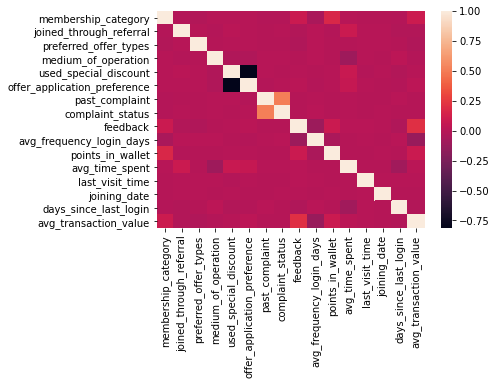

In [195]:
import seaborn as sns
sns.heatmap(X.corr())

In [196]:
X.head()

,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,avg_frequency_login_days,points_in_wallet,avg_time_spent,last_visit_time,joining_date,days_since_last_login,avg_transaction_value
0,3,1,1,0,1,1,0,1,4,17.0,781.750000,300.63,58082.0,959.0,17,53005.25
1,4,0,1,2,1,0,1,2,5,10.0,686.882199,306.34,45493.0,970.0,16,12838.38
2,2,2,1,2,0,1,1,3,3,22.0,500.690000,516.16,82401.0,680.0,14,21027.00
3,2,2,1,2,0,1,1,4,3,6.0,567.660000,53.27,57470.0,667.0,11,25239.56
4,2,1,0,3,0,1,1,2,3,16.0,663.060000,113.13,56804.0,985.0,20,24483.66


In [197]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [198]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [199]:
y_pred = model.predict(X_test)

In [200]:
from sklearn.metrics import f1_score,mean_squared_error
score = f1_score(y_test, y_pred,average="macro")
score

0.6284062517219255

In [201]:
result_df = pd.DataFrame({
    "churn_risk_score":y_pred
})

In [202]:
result_df

,churn_risk_score
0,5
1,1
2,3
3,3
4,5
...,...
1831,4
1832,4
1833,3
1834,3


In [203]:
real_test_data = pd.read_csv("dataset/test.csv")
real_test_data.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,fffe43004900440031003700300030003400,Alethia Meints,50,F,OQJ1XAY,Village,Premium Membership,2015-11-02,No,xxxxxxxx,...,12,386.26,40721.44,7.0,733.830000,Yes,No,No,Not Applicable,Poor Product Quality
1,fffe43004900440031003900370037003300,Ming Lopez,41,M,OUQRPKO,Village,Gold Membership,2016-03-01,No,xxxxxxxx,...,11,37.80,9644.40,9.0,726.000000,Yes,No,No,Not Applicable,Poor Website
2,fffe43004900440034003800360037003000,Carina Flannigan,31,F,02J2RE7,Town,Silver Membership,2017-03-03,No,xxxxxxxx,...,18,215.36,3693.25,21.0,713.780000,Yes,No,Yes,Solved in Follow-up,No reason specified
3,fffe43004900440036003200370033003400,Kyung Wanner,64,M,5YEQIF1,Town,Silver Membership,2017-08-18,Yes,CID8941,...,-999,44.57,36809.56,11.0,744.970000,Yes,No,Yes,No Information Available,Too many ads
4,fffe43004900440035003000370031003900,Enola Gatto,16,F,100RYB5,Town,No Membership,2015-05-05,Yes,CID5690,...,6,349.88,40675.86,8.0,299.048351,No,Yes,Yes,Solved in Follow-up,Poor Website


In [204]:
real_test_data = dropAllNA(real_test_data)

In [205]:
real_test_data2 = real_test_data[['age',
        'membership_category', 'joining_date',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'last_visit_time',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback']]


In [206]:
real_test_data2 = real_test_data2.fillna(real_test_data2.mean())

In [207]:
# joining_date column conversions

In [208]:
# Joining Date Columns Converted to Int
joining_date_col = pd.to_datetime(real_test_data2["joining_date"])

In [209]:
real_test_data2["joining_date"] = pd.to_datetime(real_test_data2["joining_date"])  - joining_date_col.min()

In [210]:
# df["joining_date"].value_counts()
real_test_data2["joining_date"] = real_test_data2["joining_date"] / np.timedelta64(1, 'D')
real_test_data2["joining_date"][0:10]

0    305.0
1    425.0
2    792.0
3    960.0
4    124.0
5    703.0
6    258.0
7    996.0
8    154.0
9    286.0
Name: joining_date, dtype: float64

In [211]:
real_test_data2.dtypes

age                               int64
membership_category              object
joining_date                    float64
joined_through_referral          object
preferred_offer_types            object
medium_of_operation              object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days        float64
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
dtype: object

### Last Visit Time Fix for Test

In [212]:
# pd.TimeStamp(pd.to_datetime(df["last_visit_time"],format="%H:%M:%S"))
last_visit_ns = pd.to_datetime(real_test_data2["last_visit_time"],format="%H:%M:%S")

In [213]:
ts = (last_visit_ns - np.datetime64('1900-01-01T00:00:00Z')) / np.timedelta64(1, 's')

<ipython-input-213-3235a64cf489>:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ts = (last_visit_ns - np.datetime64('1900-01-01T00:00:00Z')) / np.timedelta64(1, 's')


In [214]:
ts

0        26370.0
1        80476.0
2        60039.0
3        53777.0
4        10673.0
          ...   
19914     1963.0
19915    28477.0
19916    33997.0
19917    79154.0
19918    39015.0
Name: last_visit_time, Length: 19919, dtype: float64

In [215]:
real_test_data2["last_visit_time"] = ts

In [216]:
real_test_data2.dtypes

age                               int64
membership_category              object
joining_date                    float64
joined_through_referral          object
preferred_offer_types            object
medium_of_operation              object
last_visit_time                 float64
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days        float64
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
dtype: object

In [217]:
encoded_str = real_test_data2.select_dtypes(include="object")#.apply(label_encoder.fit_transform)

In [218]:
model_ip = encoded_str.astype(str).apply(label_encoder.fit_transform)

In [219]:
model_ip[['avg_frequency_login_days','points_in_wallet', 'avg_time_spent', 'last_visit_time', 'joining_date', 'days_since_last_login', 'avg_transaction_value']] = real_test_data2[['avg_frequency_login_days','points_in_wallet', 'avg_time_spent', 'last_visit_time', 'joining_date', 'days_since_last_login', 'avg_transaction_value']]
model_ip[['last_visit_time', 'joining_date']] = real_test_data2[['last_visit_time', 'joining_date']]
model_ip.head()

,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,avg_frequency_login_days,points_in_wallet,avg_time_spent,last_visit_time,joining_date,days_since_last_login,avg_transaction_value
0,4,1,2,3,1,0,0,1,2,7.0,733.830000,386.26,26370.0,305.0,12,40721.44
1,1,1,2,2,1,0,0,1,3,9.0,726.000000,37.80,80476.0,425.0,11,9644.40
2,5,1,1,1,1,0,1,3,0,21.0,713.780000,215.36,60039.0,792.0,18,3693.25
3,5,2,0,0,1,0,1,0,7,11.0,744.970000,44.57,53777.0,960.0,30,36809.56
4,2,2,2,3,0,1,1,3,3,8.0,299.048351,349.88,10673.0,124.0,6,40675.86


In [220]:
model_ip[['last_visit_time', 'joining_date']]

,last_visit_time,joining_date
0,26370.0,305.0
1,80476.0,425.0
2,60039.0,792.0
3,53777.0,960.0
4,10673.0,124.0
...,...,...
19914,1963.0,24.0
19915,28477.0,1095.0
19916,33997.0,251.0
19917,79154.0,472.0


In [221]:
model_ip.dtypes

membership_category               int32
joined_through_referral           int32
preferred_offer_types             int32
medium_of_operation               int32
used_special_discount             int32
offer_application_preference      int32
past_complaint                    int32
complaint_status                  int32
feedback                          int32
avg_frequency_login_days        float64
points_in_wallet                float64
avg_time_spent                  float64
last_visit_time                 float64
joining_date                    float64
days_since_last_login             int64
avg_transaction_value           float64
dtype: object

In [222]:
# str_needed = real_test_data.select_dtypes(exclude=["float64","int64"])
real_test_pred = model.predict(model_ip)

In [223]:
final_result_df = pd.DataFrame({
    "customer_id":real_test_data["customer_id"],
    "churn_risk_score":real_test_pred.astype(int)
})

In [224]:
final_result_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [225]:
final_result_df.to_csv(f"DROP-Model-{score}.csv")

In [226]:
print(score)

0.6284062517219255
